# A simple Spam filter project
Downloaded 2 files given below from http://spamassassin.apache.org/old/publiccorpus/:
* 20050311_spam_2.tar.bz2
* 20030228_easy_ham.tar.bz2

Unzipped the above files and saved in the folder (on windiws machine): 
Ham emails at: <current dir>\datasets\email\20030228_easy_ham 
Spam emails at: <current dir>\datasets\email\20050311_spam_2

We will use the *mail* package to extract the text content of the emails.

In [1]:
#Importing the required packages:

import email

import pandas as pd
import numpy as np
from IPython.display import display # Allows the use of display() for DataFrames
import time
import pickle #To save the objects that were created using webscraping
import pprint
from lxml import html
import requests
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from urllib.request import urlopen
from bs4 import BeautifulSoup
from IPython.display import HTML
import re
import urllib
import os

## Cleaning the data
Let us print an email text. This will make sure that wer are able to read the text data from the email message. We will create another set of data (cleaned data) with just the email content (removing the email header)

In [147]:
#p = 'datasets/email/20030228_easy_ham/00001.7c53336b37003a9286aba55d2945844c'
#p= './datasets/email/20030228_easy_ham/00007.37a8af848caae585af4fe35779656d55'
#p= './datasets/email/20030228_easy_ham/00014.cb20e10b2bfcb8210a1c310798532a57'
#p= './datasets/email/20030228_easy_ham/01436.dc449ba377210e77d84647619e49c872'
p= './datasets/email/20050311_spam_2/01214.973b4598b630a989967ff69b19f95d4a'

with open(p, 'r',encoding='utf-8',errors='ignore') as f:
    text = f.read()
    print(type(text))
print(list(msg.walk())    )
msg = email.message_from_string(text)
for part in msg.walk():
    print(part.get_content_type())
    # each part is a either non-multipart, or another multipart message
    # that contains further parts... Message is organized like a tree
    if part.get_content_type() == 'text/plain':
        print(part.get_payload()) # prints the raw text
    if part.get_content_type() == 'text/html':
        print(part.get_payload()) # prints the raw text        
    #if part.get_content_type() == 'multipart/alternative':
    #    print(part.get_payload()) # prints the raw text            

<class 'str'>
multipart/alternative


### Cleaning and saving the cleaned data
We will save the cleaned data into two folders:
<current dir>/datasets/email/cleaned_ham
<current dir>/datasets/email/cleaned_spam

## Functions definitions
We will use the following functions to clean the data. You can skip this section, since I will upload the cleaned data as a .csv file.

In [81]:
import re
import string
import nltk
from collections import Counter
from nltk.corpus import stopwords

def Read_File(p):
  with open(p, 'r',encoding='utf-8',errors='ignore') as f:
    #print(p)
    msg = f.read()
    msg = email.message_from_string(msg)
    #print(type(msg))
    #print(msg)
    
    for part in msg.walk():
       # each part is a either non-multipart, or another multipart message
       # that contains further parts... Message is organized like a tree
       #if part.get_content_type().lower() == 'text/plain' or part.get_content_type().lower() == 'text/html':
       if 'text/plain' in part.get_content_type().lower() or 'text/html' in part.get_content_type().lower():
           text = part.get_payload()
           #print(text)
           #Convert all the text to lower case
           #
           lowers = text.lower()
           #print(lowers)
           #remove the punctuation using the character deletion step of translate
           no_punctuation = lowers.translate(string.punctuation)
           #print(no_punctuation)
           tokens = nltk.word_tokenize(no_punctuation)
           #print(tokens)
           #return tokens
           if len(tokens) > 0:
                return tokens
           else:
                return -1
    return -1

def Remove_Stop_Words(tokens):
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    return filtered

def Clean_Text(tokens):
    text = " ".join(tokens)
    #Remove punctuation marks, text in [], (, ), :
    #filtered1 = re.sub('\.|\`|\'|\[.*\]|\(|\)|,|:|\+|_|<|>|\\|/|\{|\}', " ",text)
    filtered1 = re.sub(r'[^a-zA-Z0-9]',' ', text)
    
    #Remove any single characters
    filtered1 = re.sub('(^| ).( |$)', " ",filtered1)
    #Remove any contiguous spaces    
    filtered1 = re.sub(' +'," ",filtered1)
    
    #Include only alpha numeric characters
    filtered1=" ".join([i for i in filtered1.split() if re.search('[0-9 a-z]*',i)])
    return filtered1

def Write_Error(mail,mail_type,msg,file='errors.txt'):
    with open(file,'a') as f:
        f.write("\n"+mail+' '+mail_type)
        f.write("\n"+msg)
        

The following code will clean the data and produce a file called processed_data.csv file

In [84]:
#Process each file
y = list()
x = list()
mail_type=list()
k = 1
file_names = os.listdir("./datasets/email/20030228_easy_ham")
start = time.time()

for i in file_names:
    y.append(k)
    tokens = Read_File("./datasets/email/20030228_easy_ham/"+i)
    if tokens == -1:
        Write_Error(i,'Ham','Text Not found','errors.txt')
        continue
        
    tokens = Remove_Stop_Words(tokens)
    cleaned_text = Clean_Text(tokens)
    x.append(cleaned_text)
    mail_type.append(0)
    
    k = k+1
    if(k%100 == 0):
        temp_time = time.time() - start
        print("Processed {} files. Elapsed time:{} seconds".format(k, temp_time))

file_names = os.listdir("./datasets/email/20050311_spam_2")
for i in file_names:
    k = k+1
    y.append(k)
    tokens = Read_File("./datasets/email/20050311_spam_2/"+i)
    if tokens == -1:
        Write_Error(i,'Spam','Text Not found','errors.txt')
        continue
        
    tokens = Remove_Stop_Words(tokens)
    cleaned_text = Clean_Text(tokens)
    x.append(cleaned_text)
    mail_type.append(1)
    
    if(k%100 == 0):
        temp_time = time.time() - start
        print("Processed {} files. Elapsed time:{} seconds".format(k, temp_time))

temp_time = time.time() - start
print("Processed {} files. Elapsed time:{} seconds".format(k, temp_time))


print("Now saving the result as processed_data.csv file...")
df=pd.DataFrame(list(zip(y,x,mail_type)),columns = ["email_ID","text","mail_type"])
df.to_csv("./datasets/email/processed_data.csv",encoding='utf-8',index=False)
print("Data cleaning complete !!")

Processed 100 files. Elapsed time:14.369221210479736 seconds
Processed 200 files. Elapsed time:30.148219108581543 seconds
Processed 300 files. Elapsed time:48.544952392578125 seconds
Processed 400 files. Elapsed time:66.03262233734131 seconds
Processed 500 files. Elapsed time:85.23448538780212 seconds
Processed 600 files. Elapsed time:107.53376507759094 seconds
Processed 700 files. Elapsed time:138.08142161369324 seconds
Processed 800 files. Elapsed time:161.44909358024597 seconds
Processed 900 files. Elapsed time:177.38367891311646 seconds
Processed 1000 files. Elapsed time:202.1732234954834 seconds
Processed 1100 files. Elapsed time:216.48671126365662 seconds
Processed 1200 files. Elapsed time:230.30073070526123 seconds
Processed 1300 files. Elapsed time:242.21566152572632 seconds
Processed 1400 files. Elapsed time:257.8268840312958 seconds
Processed 1500 files. Elapsed time:269.37083864212036 seconds
Processed 1600 files. Elapsed time:284.37887358665466 seconds
Processed 1700 files.

## Model development
Reading the file...

In [148]:
##
df = pd.read_csv('./datasets/email/processed_data.csv')
df.head()

,email_ID,text,mail_type
0,1,date wed 21 aug 2002 10 54 46 0500 chris garri...,0
1,2,martin posted tassos papadopoulos greek sculpt...,0
2,3,man threatens explosion moscow thursday august...,0
3,4,klez virus wo t die already prolific virus eve...,0
4,5,adding cream spaghetti carbonara effect pasta ...,0


## Check how the target label is distributed


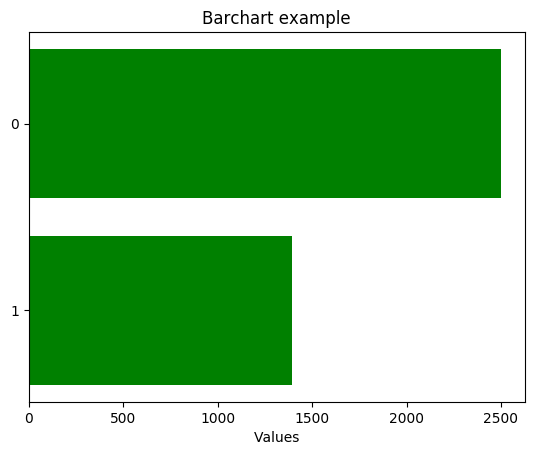

In [88]:
##How the data is distributed?
import matplotlib.pyplot as plt
plt.rcdefaults()
import numpy as np
fig, ax = plt.subplots()

values = df['mail_type'].value_counts().values
indices = list(df['mail_type'].value_counts().index)
y_pos = np.arange(len(indices))

ax.barh(y_pos, values, align='center',
        color='green' )
ax.set_yticks(y_pos)
ax.set_yticklabels(indices)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Values')
ax.set_title('Barchart example')

plt.show()


## Basic model
We can see that there are approximately 36% of spam related observations, and 64% of non-spam related observations. If we predict all the emails as non-spam, then we will get an accuracy of 64%. We will consider this model as the base model, and our goal is to beat this basic model

In [153]:
perc = values/values.sum() *  100
print("Non-spam percentage:", perc[0])
print("Spam percentage:", perc[1])

Non-spam percentage: 64.1848523748
Spam percentage: 35.8151476252


## Split the data
Let us split the data into test and train data sets. We will NOT use the test data, till the last step, to check how our model might behave on a colmpetely different set of data.

In [154]:
##Dividing the data into test/train
from sklearn.model_selection import StratifiedShuffleSplit
X = df.drop('mail_type',axis=1)
y = df['mail_type']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

## Getting the TFIDF scores
We wil quantify each word with TFIDF scores. The output will be a sparse matrix.

In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train["text"].values.astype('U'))

print("The TF-IDF matrix has {} rows and {} columns".format(tfidf_matrix.shape[0],tfidf_matrix.shape[1]))

The TF-IDF matrix has 3116 rows and 44399 columns


In [156]:
#Length of training data
len(y_train)

3116

## Training the Random Forest classifier

In [157]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(tfidf_matrix,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

## Get the cross validate predict
We will get the predictions using the CV technique on the training data. This will help us to estimate the precision, recall, accuracy and f1 score measures.

In [158]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(rf,tfidf_matrix,y_train, cv=5)

## Confusing matrix

In [101]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train,y_train_predict)

array([[1987,   13],
       [ 114, 1002]])

In [159]:
from sklearn.metrics import accuracy_score
#(1987+1002)/(1987+1002+13+114)
accuracy_score(y_train,y_train_predict)

0.96052631578947367

Accuracy of 96% is way better than the base model accuracy of 64%. So Random Forest model is definitely a suggested model to filter spam. Let us see the other performance mesaures.

In [161]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("Precison score:",precision_score(y_train,y_train_predict))
print("Recall score:", recall_score(y_train,y_train_predict))
print("F1 score:",f1_score(y_train,y_train_predict))

Precison score: 0.98250728863
Recall score: 0.905913978495
F1 score: 0.942657342657


A precision of 98% is really a good score, for spam filtering, since we are interested in improving the precision (and not recall), since we want to make sure that we will not misclassify a ham email as spam. The precision can be further improved, by increasing the cutoff probability, but I will not do that here.

## Getting the feature importances
Let us display the top 100 features used by our model

In [162]:
sorted(zip(rf.feature_importances_,tfidf_vectorizer.get_feature_names()),reverse=True)[0:100]

[(0.035620363439853128, 'border'),
 (0.031136429146829799, 'size'),
 (0.026632411815006717, '2002'),
 (0.021491890605686986, 'align'),
 (0.015894495794672427, 'you'),
 (0.015396055644128917, 'br'),
 (0.014072676850856669, 'valign'),
 (0.01220206368953998, 'height'),
 (0.011838561638309012, 'href'),
 (0.011483191101635606, 'visit'),
 (0.011270203059818419, 'ffffff'),
 (0.010742063995987644, 'url'),
 (0.010462455704310581, 'low'),
 (0.010068191297623512, 'mortgage'),
 (0.0093544770272505351, 'text'),
 (0.0090598474047168028, 'free'),
 (0.0090535782895586996, 'million'),
 (0.0085827322810476912, 'wrote'),
 (0.0080779363949716899, 'htm'),
 (0.0079961729388226474, 'click'),
 (0.0076536564451920464, 'removed'),
 (0.0076519911949355507, 'nbsp'),
 (0.0076004207894714917, 'sans'),
 (0.0064944025348859609, 'professional'),
 (0.0060286342856505862, 'program'),
 (0.005960639023587103, 'cn'),
 (0.0058961249348952922, 'dear'),
 (0.0058894497516805084, '000'),
 (0.0057003571799342937, 'date'),
 (0.00

## Developing the model using a pipeline
Now we will implement the same work using Pipeline method.

In [163]:
## Developing a pipeline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Imputer

class TFIDFTransformer(BaseEstimator, TransformerMixin):
    from sklearn.feature_extraction.text import TfidfVectorizer
    def __init__(self): #NO *args or **kargs
        return None
    
    def fit(self, X, y=None):
        self.tfidf_vectorizer=TfidfVectorizer()
        self.tfidf_vectorizer.fit(X["text"].values.astype('U'))
        return self

    
    def transform(self, X, y=None):
        return self.tfidf_vectorizer.transform(X["text"].values.astype('U'))
        
prepare_and_train = Pipeline([('tfidf',TFIDFTransformer()),('rf',RandomForestClassifier())])

In [164]:
from sklearn.model_selection import GridSearchCV
prepare_and_train.fit(X_train,y_train)
y_train_predict = cross_val_predict(prepare_and_train,X_train,y_train, cv=5)

## Getting the accuracy matrix

In [165]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train,y_train_predict)

array([[1971,   29],
       [  98, 1018]])

In [140]:
from sklearn.metrics import f1_score
f1_score(y_train,y_train_predict)

0.93808630393996251

In [166]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print("precision score:",precision_score(y_train,y_train_predict))
print("recall score:",recall_score(y_train,y_train_predict))
print("F1 score:",f1_score(y_train,y_train_predict))
print("accuracy score:",accuracy_score(y_train,y_train_predict))

precision score: 0.972301814709
recall score: 0.912186379928
F1 score: 0.941285251965
accuracy score: 0.959242618742


## Model evaluation on the test data
Let us evaluate our model on the test data

In [167]:
#Getting the test score finally:
y_test_predict=prepare_and_train.predict(X_test)

In [168]:
print("Test f1 score:",f1_score(y_test,y_test_predict))
print("Test precision score:",precision_score(y_test,y_test_predict))
print("Test recall score:",recall_score(y_test,y_test_predict))
print("Test accuracy score:",accuracy_score(y_test,y_test_predict))

Test f1 score: 0.955056179775
Test precision score: 1.0
Test recall score: 0.913978494624
Test accuracy score: 0.96919127086


## Conclusion
The test evaluation also shows that we are getting very good precision score, so our model based on the Random Forest Classifier is good.